In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import semisupervised_vae_lib as ss_vae_lib

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F

import cifar_data_utils
from cifar_vae_lib import CIFARConditionalVAE
from cifar_classifier_lib import Wide_ResNet
import cifar_semisupervised_lib


In [2]:
seed = 13423
np.random.seed(seed)
_ = torch.manual_seed(seed)


# Load data

In [3]:
train_set_labeled, train_set_unlabeled, test_set = \
    cifar_data_utils.load_semisupervised_cifar_dataset(propn_sample=0.001, 
                                                      propn_labeled = 0.1)

| Preparing CIFAR-100 dataset...
Files already downloaded and verified
| Preparing CIFAR-100 dataset...
Files already downloaded and verified
| Preparing CIFAR-100 dataset...
Files already downloaded and verified


In [4]:
print('num_train_labeled: ', train_set_labeled.num_images)
print('num_train_unlabled: ', train_set_unlabeled.num_images)

print('num_test: ', test_set.num_images)

num_train_labeled:  5
num_train_unlabled:  45
num_test:  10


In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

labels_legend_all = unpickle('../cifar100_data/cifar-100-python/meta')
fine_labels_legend = labels_legend_all[b'fine_label_names']

In [6]:
def plot_cifar_image(image, label):
    image_unscaled = image * cifar_data_utils.CIFAR_STD_TENSOR + cifar_data_utils.CIFAR_MEAN_TENSOR

    img = np.dstack((image_unscaled[0, :, :],
                            image_unscaled[1, :, :],
                            image_unscaled[2, :, :]))

    plt.imshow(img)
    plt.title(fine_labels_legend[label])

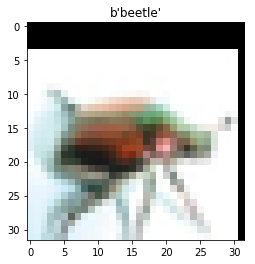

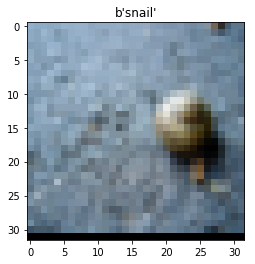

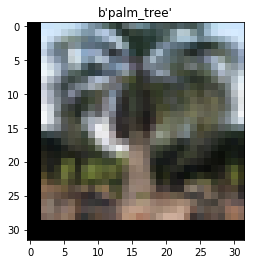

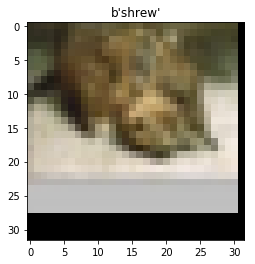

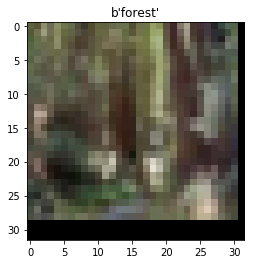

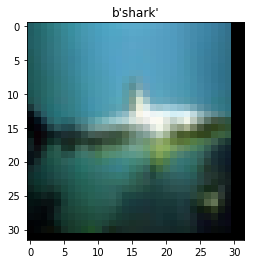

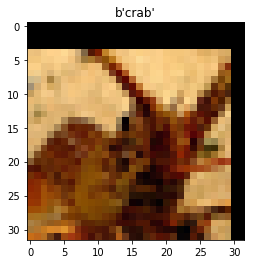

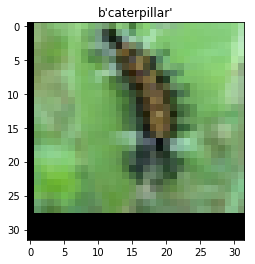

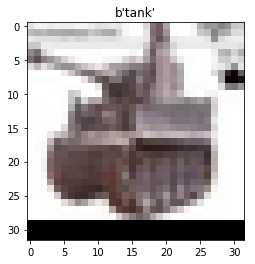

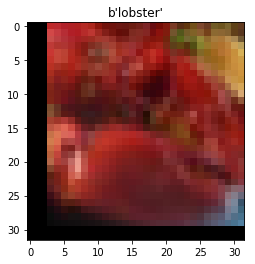

In [7]:
for i in range(10): 
    # train_set_labeled[i]['image']
    plt.figure()
    plot_cifar_image(train_set_unlabeled[i]['image'].squeeze(), train_set_unlabeled[i]['label'])

In [8]:
slen = train_set_labeled[0]['image'].shape[-1]

# Get data loaders

In [9]:
batchsize = 12

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=train_set_labeled.num_images,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [10]:
for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [11]:
data_unlabeled['image'].shape

torch.Size([12, 3, 32, 32])

In [12]:
data_labeled['image'].shape

torch.Size([5, 3, 32, 32])

In [13]:
data_test['image'].shape

torch.Size([10, 3, 32, 32])

# Define VAE

In [14]:
image_config = {'slen': 32,
                 'channel_num': 3,
                 'n_classes': 100}

cond_vae_config = {'kernel_num': 5,
                   'z_size': 2}

classifier_config = {'depth': 10,
                     'widen_factor': 2,
                     'dropout_rate': 0.3}

In [15]:
cifar_vae = \
    cifar_semisupervised_lib.get_cifar_semisuperivsed_vae(image_config, cond_vae_config, classifier_config)

| Wide-Resnet 10x2


## check conditional vae

In [16]:
latent_means, latent_std, latent_samples, image_mean, image_var = \
    cifar_vae.conditional_vae.forward(data_unlabeled['image'], data_unlabeled['label'])

In [17]:
image_mean.shape

torch.Size([12, 3, 32, 32])

In [18]:
latent_means.shape

torch.Size([12, 2])

In [19]:
latent_std.shape

torch.Size([12, 2])

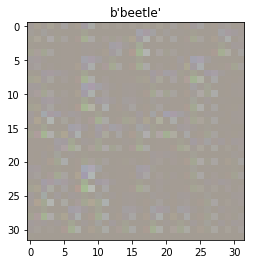

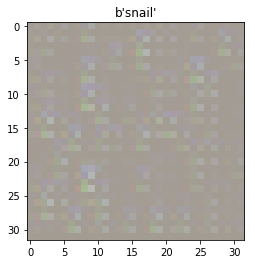

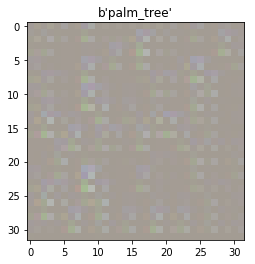

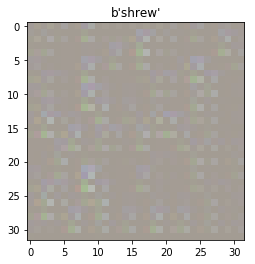

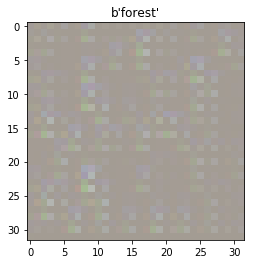

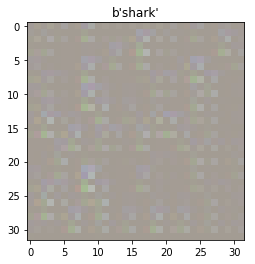

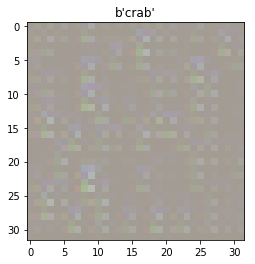

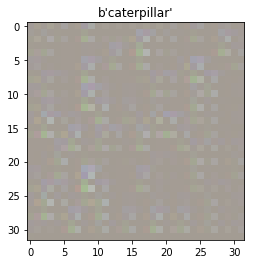

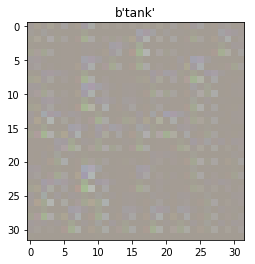

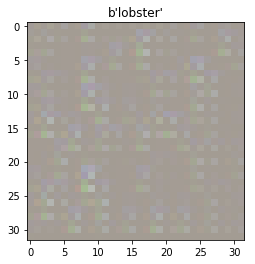

In [20]:
for i in range(10): 
    # train_set_labeled[i]['image']
    plt.figure()
    plot_cifar_image(image_mean[0].detach(), train_set_unlabeled[i]['label'])

### check classifier

In [21]:
log_q = cifar_vae.classifier.forward(data_unlabeled['image'])

In [22]:
assert np.all(log_q.detach().numpy() < 0)

In [23]:
print(log_q.shape)

torch.Size([12, 100])


### check loss goes through

In [25]:
cond_loss = cifar_vae.get_conditional_loss(data_unlabeled['image'], data_unlabeled['label'])

In [26]:
assert len(cond_loss) == len(data_unlabeled['label'])

In [27]:
cond_loss

tensor([-31717.5918, -31717.5918, -31717.5918, -31717.5918, -31717.5898,
        -31717.5918, -31717.5918, -31717.5918, -31717.5898, -31717.5918,
        -31717.5918, -31717.5918])

In [28]:
cifar_vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 1000,
                            use_baseline = True,
                            alpha = 1.0, topk = 0)

(tensor(-3.1293e+07), tensor(1.00000e+05 *
        -3.7884))

# Check gradient works 

In [29]:
def get_vae_params(vae): 
    vae_params = np.array([])
    for f in vae.parameters(): 
        vae_params = np.append(vae_params, f.detach().numpy().flatten())
    return vae_params


In [30]:
vae_params0 = get_vae_params(cifar_vae)

In [31]:
assert np.any(np.isnan(vae_params0)) == False

In [32]:
optimizer = optim.Adam(cifar_vae.parameters(), lr=0.01)
optimizer.zero_grad()

In [33]:
loss, map_loss1 = cifar_vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 100, 
                            use_baseline = True,
                            alpha = 1.0, topk = 0)
print(map_loss1)

tensor(1.00000e+05 *
       -3.7863)


In [34]:
loss.backward()
optimizer.step()

In [35]:
vae_params1 = get_vae_params(cifar_vae)

In [36]:
assert np.any(np.isnan(vae_params1)) == False

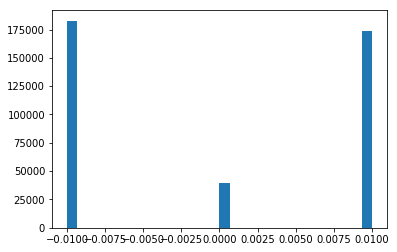

In [37]:
plt.hist(vae_params1 - vae_params0, bins = 30); 

In [38]:
loss, map_loss2 = cifar_vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 100,
                            use_baseline = True,
                            alpha = 1.0, topk = 0)


In [39]:
map_loss2

tensor(1.00000e+05 *
       -3.9258)

In [40]:
assert np.isfinite(loss.detach().numpy())

# Test training

In [41]:
from torch.utils.data.sampler import Sampler

In [42]:
ss_vae_lib.train_semisupervised_model(cifar_vae, train_loader_unlabeled, 
                                        data_labeled['image'], 
                                        data_labeled['label'], 
                                        test_loader, 
                                        n_epoch = 5, print_every = 2, outfile = './test', 
                                        use_true_labels = False)

  * init train recon loss: -25106.01172;
  * init test recon loss: -21766.81641;
  * init labeled class accuracy:    0;
  * init train class accuracy: 0.02222;
  * init test class accuracy:    0;
[1] unlabeled_loss: -30741.32812  	[1.4 seconds]
[2] unlabeled_loss: -30997.2832  	[1.4 seconds]
  * train recon loss: -25320.92578;
  * test recon loss: -21817.81836;
  * labeled class accuracy:    0;
  * train class accuracy: 0.02222;
  * test class accuracy:    0;
[3] unlabeled_loss: -31323.01562  	[1.6 seconds]
[4] unlabeled_loss: -31942.85156  	[1.7 seconds]
  * train recon loss: -29864.90234;
  * test recon loss: -23978.20703;
  * labeled class accuracy:    0;
  * train class accuracy: 0.02222;
  * test class accuracy:    0;
[5] unlabeled_loss: -31860.21484  	[1.6 seconds]
writing the encoder parameters to ./test_enc_final

writing the decoder parameters to ./test_dec_final

writing the classifier parameters to ./test_classifier_final



In [44]:
torch.exp(cifar_vae.classifier(data_unlabeled['image']).detach())

tensor(1.00000e-02 *
       [[ 2.2906,  1.1299,  1.0061,  ...,  0.9190,  0.6920,  0.9689],
        [ 1.5536,  0.9954,  0.9891,  ...,  0.9162,  0.9776,  0.9529],
        [ 2.0809,  1.1284,  0.9056,  ...,  0.8870,  0.8681,  0.9306],
        ...,
        [ 1.2308,  0.9860,  0.9729,  ...,  0.9361,  0.9437,  0.9106],
        [ 1.3393,  0.9224,  0.9466,  ...,  0.9264,  0.9788,  0.9088],
        [ 1.4874,  0.9739,  0.9239,  ...,  0.8352,  1.0685,  0.8991]])

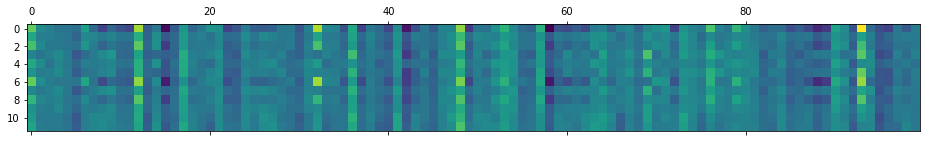

In [45]:
plt.matshow(cifar_vae.classifier(data_unlabeled['image']).detach())

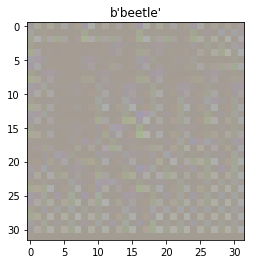

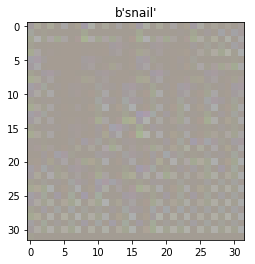

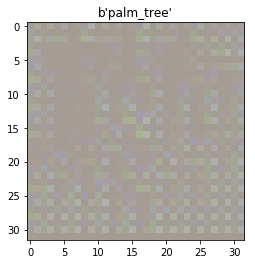

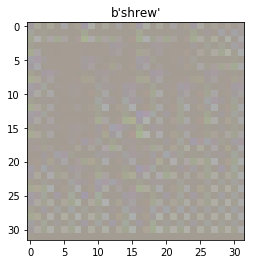

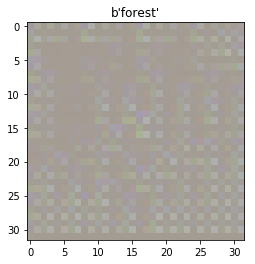

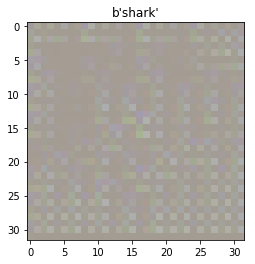

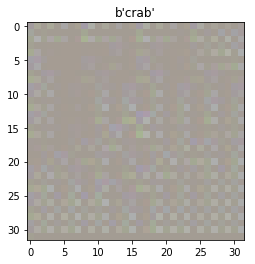

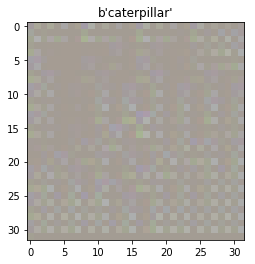

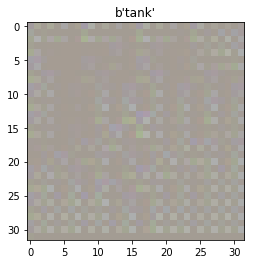

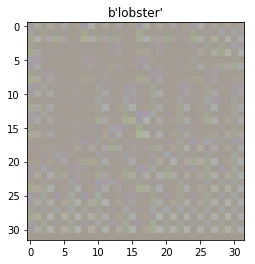

In [49]:
latent_means, latent_std, latent_samples, image_mean, image_var = \
    cifar_vae.conditional_vae.forward(data_unlabeled['image'], data_unlabeled['label'])
    
for i in range(10): 
    # train_set_labeled[i]['image']
    plt.figure()
    plot_cifar_image(image_mean[0].detach(), train_set_unlabeled[i]['label'])

In [50]:
# check reloading

In [52]:
reload_cifar_vae = \
    cifar_semisupervised_lib.get_cifar_semisuperivsed_vae(image_config, cond_vae_config, classifier_config)

# mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
#                                     n_classes = n_classes)

| Wide-Resnet 10x2


In [60]:
enc_file = "./test_enc_final"
dec_file = './test_dec_final'
classifier_file = './test_classifier_final'

reload_cifar_vae.conditional_vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

reload_cifar_vae.conditional_vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))

reload_cifar_vae.classifier.load_state_dict(torch.load(classifier_file,
                               map_location=lambda storage, loc: storage))


In [61]:
reload_cifar_vae.eval_vae(train_loader_unlabeled, data_labeled['image'], 
                                        data_labeled['label'])

tensor(-33573.4258)